# Stitching tiled electron microscopy data

This notebook demonstrates how to use SOFIMA to build seamless section images out of a tiled acquisition. To do so, we have to identify the extent of the matching content between nearby tiles (highlighted in red below), estimate the relative position of the tiles (note how the right tile is shifted down slightly), as well as build a detailed correspondence map that will allow us to warp data from one tile onto the other with pixel precision.


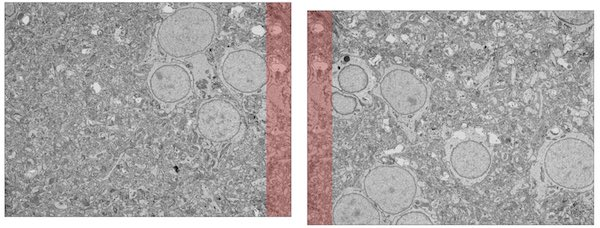

# Prerequisites

For best performance, use a GPU accelerated kernel. If using Google Colab, you can select the accelerator type in `Edit->Notebook settings`.

Note that the accelerated code uses JAX, which incurs compilation overhead on the first invocation of jitted functions. Subsequent runs of the same function will be faster.

In [ ]:
!pip install git+https://github.com/google-research/sofima

In [ ]:
import functools as ft
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import PIL

# Data preparation

To start, we download some sample data to work with. We will be using a 3x3 tile sample from a [SBEM](https://en.wikipedia.org/wiki/Serial_block-face_scanning_electron_microscopy) dataset of zebrafish brain acquired by [Rainer Friedrich's](https://www.fmi.ch/research-groups/groupleader.html?group=119) lab at the FMI.

In [ ]:
%mkdir tiles
!gsutil -m rsync -r gs://sofima-sample-data/fmi-friedrich-dp tiles

In [ ]:
# Define the tile space. This specifies how the different tiles are distributed
# in space, and should normally be derived from the metadata provided by the
# microscope.
tile_id_map = [[461, 462, 463],
               [493, 494, 495],
               [525, 526, 527]]
tile_id_map = np.array(tile_id_map)

In [ ]:
# Load tile images.
tile_map = {}

for y in range(tile_id_map.shape[0]):
  for x in range(tile_id_map.shape[1]):
    tile_id = tile_id_map[y, x]
    with open(f'tiles/20210630_Dp_190326Bb_run04_g0001_t0{tile_id}_s04734.png', 'rb') as fp:
      img = PIL.Image.open(fp)
      tile_map[(x, y)] = np.array(img)

# Coarse tile position optimization

Starting from the rough tile positions implicitly defined in `tile_map`, we first estimate a coarse relative positions for every nearest neighbor tile pair.


In [ ]:
from sofima import stitch_rigid
tile_space = (3, 3)
cx, cy = stitch_rigid.compute_coarse_offsets(tile_space, tile_map)

In [ ]:
# Visualize the relative positions of horizontal and vertical nearest neighbors.
# Every vector represents a tile *pair*.
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].quiver((0, 1, 2), (0, 1, 2), cx[0, 0, ...], cx[1, 0, ...])
ax[0].set_ylim(-0.5, 2.5)
ax[0].set_xlim(-0.5, 1.5)
ax[0].set_title('horizontal NNs')
ax[1].quiver((0, 1, 2), (0, 1, 2), cy[0, 0, ...], cy[1, 0, ...])
ax[1].set_ylim(-0.5, 1.5)
ax[1].set_xlim(-0.5, 2.5)
ax[1].set_title('vertical NNs')

Next, we use the information from the previous step to set up and solve a simple optimization problem. Here, every node of an elastic mesh represents a complete tile. The tiles are kept rigid and only allowed to move translationally. 

In [ ]:
coarse_mesh = stitch_rigid.optimize_coarse_mesh(cx, cy)

In [ ]:
# Visualize the results. Every vector represents a tile.
plt.quiver((0, 1, 2), (0, 1, 2), coarse_mesh[0, 0, ...], coarse_mesh[1, 0, ...])

# Fine tile position optimization

Starting from the relative positions of tile pairs estimated in the previous step, we now proceed to computing a flow field for every pair of neighboring tiles. This flow field is dense, but at a reduced resolution in comparison to the image. The resolution is controlled by the `stride` parameter.

In [ ]:
from sofima import stitch_elastic

# The stride (in pixels) specifies the resolution at which to compute the flow
# fields between tile pairs. This is the same as the resolution at which the
# mesh is later optimized. The more deformed the tiles initially are, the lower
# the stride needs to be to get good stitching results.
stride = 20
cx = np.squeeze(cx)
cy = np.squeeze(cy)
fine_x, offsets_x = stitch_elastic.compute_flow_map(tile_map, cx, 0, stride=(stride, stride), batch_size=4)  # (x,y) -> (x+1,y)
fine_y, offsets_y = stitch_elastic.compute_flow_map(tile_map, cy, 1, stride=(stride, stride), batch_size=4)  # (x,y) -> (x,y+1)

The estimated flow fields might be locally inconsistent or contain invalid entries where locally there is insufficient high frequency image content to establish a good match between the images. We can optionally apply clean up
procedures and filter the flow fields by estimated quality of the flow vector (`min_peak_ratio`, `min_peak_sharpness`) as well as by spatial consistency of the field (`max_deviation`, `min_patch_size`, etc).

In [ ]:
from sofima import flow_utils

kwargs = {"min_peak_ratio": 1.4, "min_peak_sharpness": 1.4, "max_deviation": 5, "max_magnitude": 0}
fine_x = {k: flow_utils.clean_flow(v[:, np.newaxis, ...], **kwargs)[:, 0, :, :] for k, v in fine_x.items()}
fine_y = {k: flow_utils.clean_flow(v[:, np.newaxis, ...], **kwargs)[:, 0, :, :] for k, v in fine_y.items()}

kwargs = {"min_patch_size": 10, "max_gradient": -1, "max_deviation": -1}
fine_x = {k: flow_utils.reconcile_flows([v[:, np.newaxis, ...]], **kwargs)[:, 0, :, :] for k, v in fine_x.items()}
fine_y = {k: flow_utils.reconcile_flows([v[:, np.newaxis, ...]], **kwargs)[:, 0, :, :] for k, v in fine_y.items()}

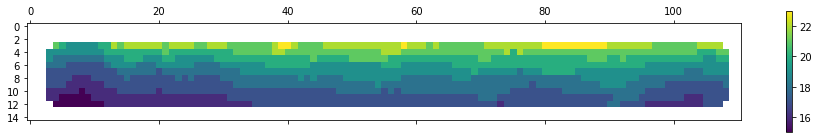

In [ ]:
# Visualize the X component of the flow field between the tiles
# (0, 0) and (1, 0). Note that this is flipped by 90 degrees
# to better utilize screen space.
plt.matshow(fine_x[0, 0][0, ...].T)
plt.colorbar()

Next, we prepare the data for the mesh solver.

In [ ]:
from sofima import mesh

data_x = (cx, fine_x, offsets_x)
data_y = (cy, fine_y, offsets_y)

fx, fy, x, nbors, key_to_idx = stitch_elastic.aggregate_arrays(
    data_x, data_y, list(tile_map.keys()),
    coarse_mesh[:, 0, ...], stride=(stride, stride),
    tile_shape=next(iter(tile_map.values())).shape)

@jax.jit
def prev_fn(x):
  target_fn = ft.partial(stitch_elastic.compute_target_mesh, x=x, fx=fx,
                         fy=fy, stride=(stride, stride))
  x = jax.vmap(target_fn)(nbors)
  return jnp.transpose(x, [1, 0, 2, 3])

# These detault settings are expect to work well in most configurations. Perhaps
# the most salient parameter is the elasticity ratio k0 / k. The larger it gets,
# the more the tiles will be allowed to deform to match their neighbors (in which
# case you might want use aggressive flow filtering to ensure that there are no
# inaccurate flow vectors). Lower ratios will reduce deformation, which, depending
# on the initial state of the tiles, might result in visible seams.
config = mesh.IntegrationConfig(dt=0.001, gamma=0., k0=0.01, k=0.1, stride=stride,
                                num_iters=1000, max_iters=20000, stop_v_max=0.001,
                                dt_max=100, prefer_orig_order=True,
                                start_cap=0.1, final_cap=10., remove_drift=True)

In the following, each tile will be modeled as a spring mesh (see blue edges and red nodes below), and we will be looking for its equilibrium state. There will be two types of forces acting on every node of the mesh -- the spring elastic force (which tries to preserve the original tile geometry), and a force
proportial to the estimated flow field (green arrows below), which will pull the
tile into alignment with its neighbors. Note that the force might not be applied
to some nodes (in cases we do not have a flow field estimate; shown as nodes
without arrows below).


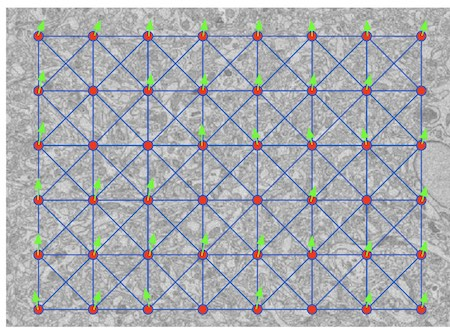

In [ ]:
x, ekin, t = mesh.relax_mesh(x, None, config, prev_fn=prev_fn)

Now that the mesh is solved we are ready to render the stitched section.

In [ ]:
from sofima import warp

# Unpack meshes into a dictionary.
idx_to_key = {v: k for k, v in key_to_idx.items()}
meshes = {idx_to_key[i]: np.array(x[:, i:i+1 :, :]) for i in range(x.shape[1])}

# Warp the tiles into a single image.
stitched, mask = warp.render_tiles(tile_map, meshes, stride=(stride, stride))

In [ ]:
# Visualize the stitched tiles with matplotlib..
plt.figure(figsize=(15, 10))
plt.imshow(stitched, cmap=plt.cm.Greys_r)

In [ ]:
# Zoom in on one of the seams.
plt.figure(figsize=(25, 5))
plt.imshow(stitched[3800:-200, 2900:3200].T, cmap=plt.cm.Greys_r)

In [ ]:
# .. or inspect it interactively in Neuroglancer.
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y'], units='nm', scales=[11, 11])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(stitched.T, dimensions))

viewer